In [1]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [2]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

NameError: name 'bigquery_client' is not defined

In [3]:
test_df.drop_duplicates()

NameError: name 'test_df' is not defined

In [4]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [5]:
get_ipython().run_cell_magic('capture', '', "\n#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n\n!python3 -m pip install pandas\n!pip install chardet\n!pip install db-dtypes\n!pip install catboost\n")

In [6]:
#Importing Libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import csv
import numpy as np

In [8]:
from google.cloud import bigquery
import scipy as sp
import statsmodels as sm
import statistics as stat
import sklearn
import patsy as pt
import chardet as ch
import click as cl
import cytoolz as cz
import dask
import decorator as dr
#import pyjson5 as py
import jsonschema as js
import tables
import db_dtypes
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

ModuleNotFoundError: No module named 'chardet'

In [9]:
global df3

In [10]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [11]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [12]:
query_job1 = bigquery_client.query(query)
query_job1

QueryJob<project=ironhacks-data, location=US, id=f9457191-ce5a-4f80-b536-b9e6977ea132>

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
"""

In [14]:
query_job2 = bigquery_client.query(query)
query_job2

QueryJob<project=ironhacks-data, location=US, id=5e2ac755-ac3c-4979-aeeb-2f63873af459>

In [15]:
!pip install db-dtypes
df1 = query_job2.to_dataframe()
df1.uu_id.nunique()

525

In [16]:
!pip install db-dtypes
df2 = query_job1.to_dataframe()
df2.uu_id.nunique()

525

In [17]:
df3 = pd.merge(df1,df2, on= ["uu_id","countyfips","tract","tract_name"])

In [18]:
#Expanding timeperiod to day, month and year
df3["time"] = pd.to_datetime(df3["timeperiod"], format= '%Y%m%d', errors = "coerce")
df3 =df3.drop("timeperiod", axis = 1)
df3["month"] = df3["time"].dt.month
df3["day"] = df3["time"].dt.day
str_col = ["tract_name", 'top_category_employer1', 'top_category_employer2',
       'top_category_employer3',"time"]
df3["uu_id_enc"] = df3["uu_id"].astype('category').cat.codes
#Encoding Strings
for col in str_col :
    df3[col] = df3[col].astype('category').cat.codes
int_col = list(set(df3.columns) -set(str_col)-set(["uu_id"]))
#dropping and replacing Nan, NaT   
df3 =df3.astype(str)
df3 = df3[df3["uu_id"] != np.nan]
df3 = df3.replace('NaT', np.nan)
df3 = df3.replace(str(np.nan),str(0))
#df3 = df3.dropna(subset = ["uu_id"], inplace=True)
for col in df3.columns:
    df3[col] = df3[col].str.replace(str("<NA>"),"0")
for col in int_col:
    df3[col] =df3[col].astype(float)
df = df3.copy()
df3.uu_id.nunique()

525

In [19]:
df3 = df.copy()
df3.columns

Index(['uu_id', 'week_number', 'countyfips', 'tract', 'tract_name',
       'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage',
       'time', 'month', 'day', 'uu_id_enc'],
      dtype='object')

In [20]:
races = ['race_black', 'race_other', 'race_white']
#for j in races:
g = (sum([df3[k] for k in races]))
df3["normalized_"+ str("races") ] = g
df3["normalized_"+ str("races") ].unique()

array([ 11.,   0.,  15.,  14.,  20.,  17.,  10.,  32.,  34.,  22.,  25.,
        46.,  60.,  29.,  42.,  16.,  12.,  21.,  39.,  13.,  57.,  55.,
        43.,  18.,  92.,  24.,  19.,  82.,  90., 142.,  47.,  33.,  75.,
       135.,  31.,  26.,  73.,  28., 109.,  37.,  23.,  27.,  30.,  38.,
        41.,  52.,  45.,  71.,  61.,  40.,  44.,  84.,  36.,  35.,  53.,
        89.,  70.,  64.,  63.,  59.,  49.,  68.,  51.,  76.,  58.,  65.,
        50.,  79.,  48.,  56.,  69.,  62.,  72.,  74.,  54.,  66.,  85.,
       105., 101., 140.,  83.,  87.,  96., 103.,  97.,  77., 138.,  67.,
        81.,  86., 117., 111.,  88.,  91., 128.,  93., 108., 155., 163.,
        99.,  78.,  80., 107., 100.,  95., 112., 110.,  94.])

In [21]:
ed = ['edu_grades_9_11','edu_hs_grad_equiv', 'edu_post_hs']
for j in ed:
    df3["normalized_"+ str("education") ] = sum([df3[k] for k in ed])

In [22]:
gen = [ 'gender_female', 'gender_male']
for j in gen:
    df3["normalized_"+ str("gender") ] = sum([df3[k] for k in gen])

In [23]:
df3["sum"] = (df3["normalized_"+ str("education") ]+df3["normalized_"+ str("races") ]+df3["normalized_"+ str("gender") ])

In [24]:
def opt_features(x):
    df3["opt_var"]= (x[3]*df3["normalized_"+ str("education") ]**x[0]+x[4]*df3["normalized_"+ str("races") ]**x[1]+x[5]*df3["normalized_"+ str("gender") ]**x[2]+x[6])
    df4 =df3.corr()
    corr = -df4.loc["opt_var","total_claims"]
    return corr
import scipy   
op = scipy.optimize.minimize(opt_features, [1]*7,method="SLSQP") 
op

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_13557/3549868753.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 =df3.corr()


     fun: -0.939114895616644
     jac: array([ 4.24385071e-05, -2.17661262e-04,  1.90749764e-04,  5.78165054e-06,
       -2.16342509e-04,  2.59578228e-04,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 244
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([1.04031784, 1.33646238, 1.36444524, 2.26265948, 0.35521683,
       0.23040335, 1.        ])

In [25]:
def opt_features2(x):
    #corr = -df4.loc["opt_var1","total_claims"]
    df3["opt_var2"]=x[0]*df3["opt_var"]+x[1]*df3["week_number"]
    df3["error"]= df3["total_claims"]-df3["opt_var2"]
    return abs(df3["error"]).sum()
cons = ({'type': 'ineq',
       'fun': lambda x:  opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  -opt_features2(x)
       },
        {'type': 'ineq',
       'fun': lambda x:  x[1]-1
       })
op2 = scipy.optimize.minimize(opt_features2, [1]*7,method="SLSQP", constraints = cons) 
op2

     fun: 817140.3252665871
     jac: array([815493.328125, 337886.      ,      0.      ,      0.      ,
            0.      ,      0.      ,      0.      ])
 message: 'Positive directional derivative for linesearch'
    nfev: 8
     nit: 5
    njev: 1
  status: 8
 success: False
       x: array([1., 1., 1., 1., 1., 1., 1.])

In [26]:
df3["opt_var2"]=df3["opt_var"]+df3["opt_var2"]

In [27]:
df4 = df3.corr()
df4

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_13557/3822703957.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4 = df3.corr()


,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
week_number,1.000000,-0.001015,-0.007765,-0.054817,0.019532,0.003564,-0.073129,0.003422,-0.006047,-0.033730,...,0.994291,0.025037,-0.006156,-0.048913,-0.054185,-0.039989,-0.052532,-0.048836,0.029686,-0.144117
countyfips,-0.001015,1.000000,0.014993,-0.011242,-0.002837,-0.003048,-0.005792,-0.019259,0.009003,-0.021396,...,-0.000952,0.000457,-0.015962,-0.024707,-0.015422,-0.025740,-0.024637,-0.024669,-0.024768,0.027394
tract,-0.007765,0.014993,1.000000,-0.041477,0.038854,-0.001890,-0.043448,-0.022050,0.005409,-0.020104,...,-0.007176,-0.007065,0.063204,-0.010364,-0.045897,-0.025235,-0.030135,-0.034989,-0.035625,0.033961
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_8th_or_less,0.019532,-0.002837,0.038854,0.069029,1.000000,-0.001538,0.013054,-0.006682,-0.002748,0.039022,...,0.020405,-0.008325,-0.011235,0.056605,0.006240,0.049529,0.042334,0.034951,0.036512,-0.029577
edu_grades_9_11,0.003564,-0.003048,-0.001890,0.267877,-0.001538,1.000000,0.063023,0.017355,-0.001633,0.205276,...,0.003867,-0.003019,-0.019018,0.198873,0.267673,0.206088,0.248195,0.266347,0.266828,-0.259388
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
edu_unknown,-0.006047,0.009003,0.005409,0.107267,-0.002748,-0.001633,0.011754,0.006395,1.000000,0.052286,...,-0.005783,-0.002308,0.004989,0.068465,0.012197,0.052776,0.049885,0.040790,0.040346,-0.022657
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378


In [28]:
df4[abs(df4.total_claims)>0.5]
#df4.loc["ult","total_claims"]

,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
total_claims,-0.054817,-0.011242,-0.041477,1.000000,0.069029,0.267877,0.739960,0.500470,0.107267,0.724440,...,-0.052776,-0.020447,-0.001522,0.790695,0.897792,0.805103,0.922510,0.939115,0.935516,-0.888512
edu_hs_grad_equiv,-0.073129,-0.005792,-0.043448,0.739960,0.013054,0.063023,1.000000,0.052999,0.011754,0.557907,...,-0.070333,-0.027185,-0.005291,0.594066,0.817667,0.627753,0.752760,0.787299,0.782148,-0.763195
edu_post_hs,0.003422,-0.019259,-0.022050,0.500470,-0.006682,0.017355,0.052999,1.000000,0.006395,0.375024,...,0.003506,-0.001779,0.020953,0.405391,0.578977,0.413722,0.514986,0.541453,0.542129,-0.537103
gender_female,-0.033730,-0.021396,-0.020104,0.724440,0.039022,0.205276,0.557907,0.375024,0.052286,1.000000,...,-0.032995,-0.009440,-0.000822,0.608157,0.676363,0.904675,0.822653,0.774904,0.772838,-0.759378
gender_male,-0.038832,-0.025299,-0.025640,0.738217,0.050745,0.169898,0.582283,0.376703,0.043780,0.650736,...,-0.036812,-0.022545,-0.002551,0.606272,0.688769,0.912246,0.829481,0.783698,0.781238,-0.765772
race_black,-0.057827,0.010962,-0.015516,0.594516,0.012987,0.123855,0.470553,0.291321,0.051318,0.484824,...,-0.059313,0.018327,-0.003819,0.670411,0.546791,0.489177,0.626942,0.625425,0.621353,-0.604729
normalized_races,-0.048913,-0.024707,-0.010364,0.790695,0.056605,0.198873,0.594066,0.405391,0.068465,0.608157,...,-0.046182,-0.027418,-0.004696,1.000000,0.719309,0.668324,0.876010,0.843832,0.840626,-0.824175
normalized_education,-0.054185,-0.015422,-0.045897,0.897792,0.006240,0.267673,0.817667,0.578977,0.012197,0.676363,...,-0.051906,-0.022683,0.003102,0.719309,1.000000,0.751417,0.911358,0.956107,0.952571,-0.933617
normalized_gender,-0.039989,-0.025740,-0.025235,0.805103,0.049529,0.206088,0.627753,0.413722,0.052776,0.904675,...,-0.038459,-0.017745,-0.001875,0.668324,0.751417,1.000000,0.909304,0.857851,0.855356,-0.839415
sum,-0.052532,-0.024637,-0.030135,0.922510,0.042334,0.248195,0.752760,0.514986,0.049885,0.822653,...,-0.050152,-0.024817,-0.001318,0.876010,0.911358,0.909304,1.000000,0.983235,0.979849,-0.960895


In [29]:
features =df4[abs(df4.total_claims)>0.6].index
features

Index(['total_claims', 'edu_hs_grad_equiv', 'gender_female', 'gender_male',
       'normalized_races', 'normalized_education', 'normalized_gender', 'sum',
       'opt_var', 'opt_var2', 'error'],
      dtype='object')

total_claims (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


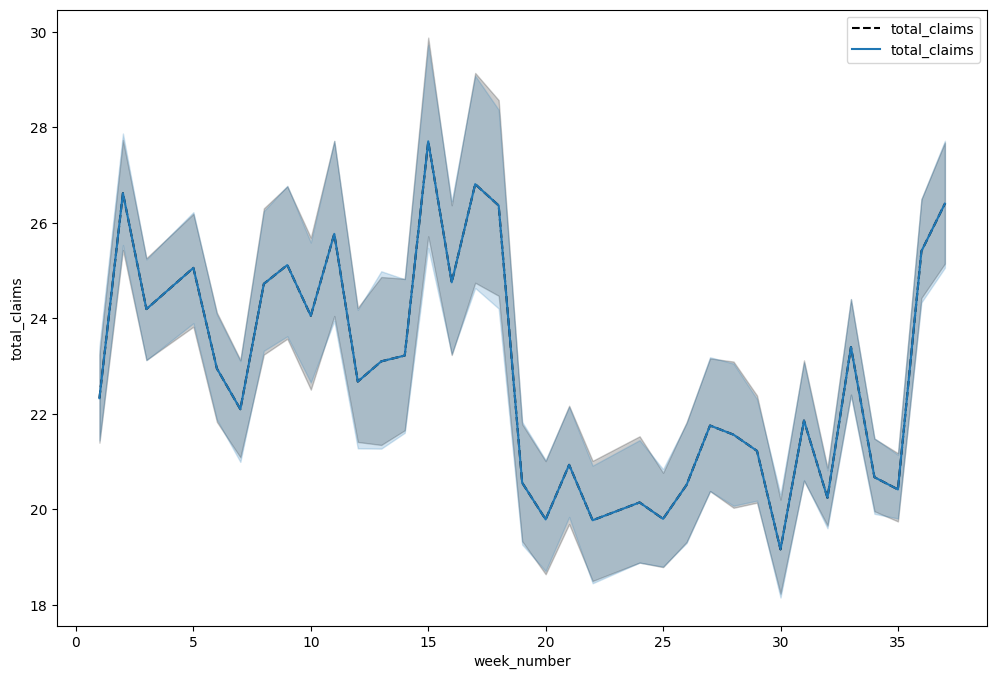

edu_hs_grad_equiv (1.0, 0.4980392156862745, 0.054901960784313725)


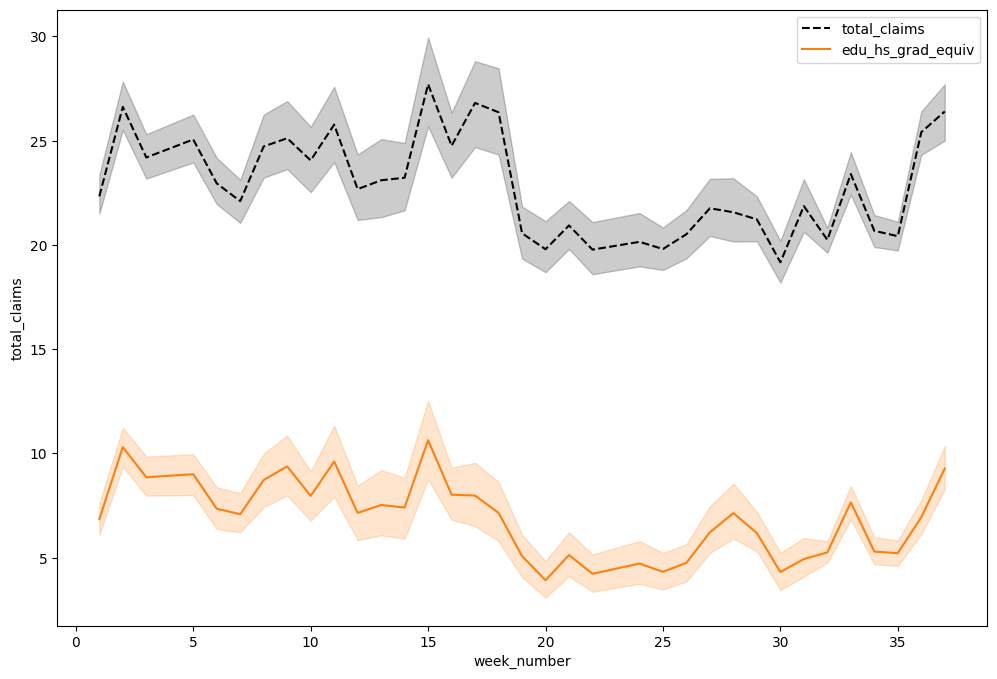

gender_female (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


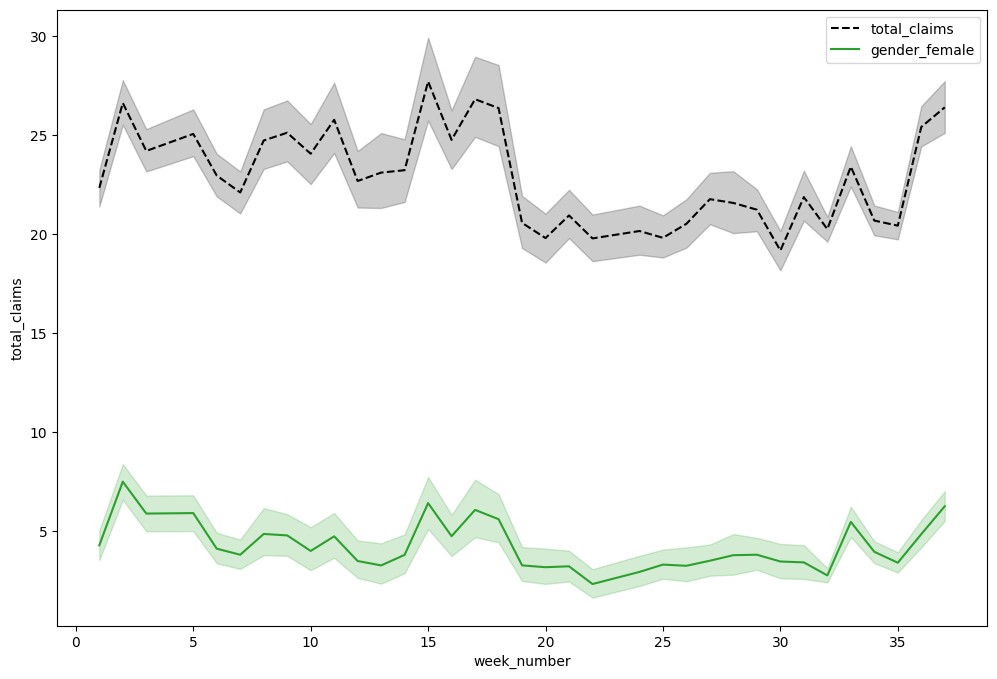

gender_male (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)


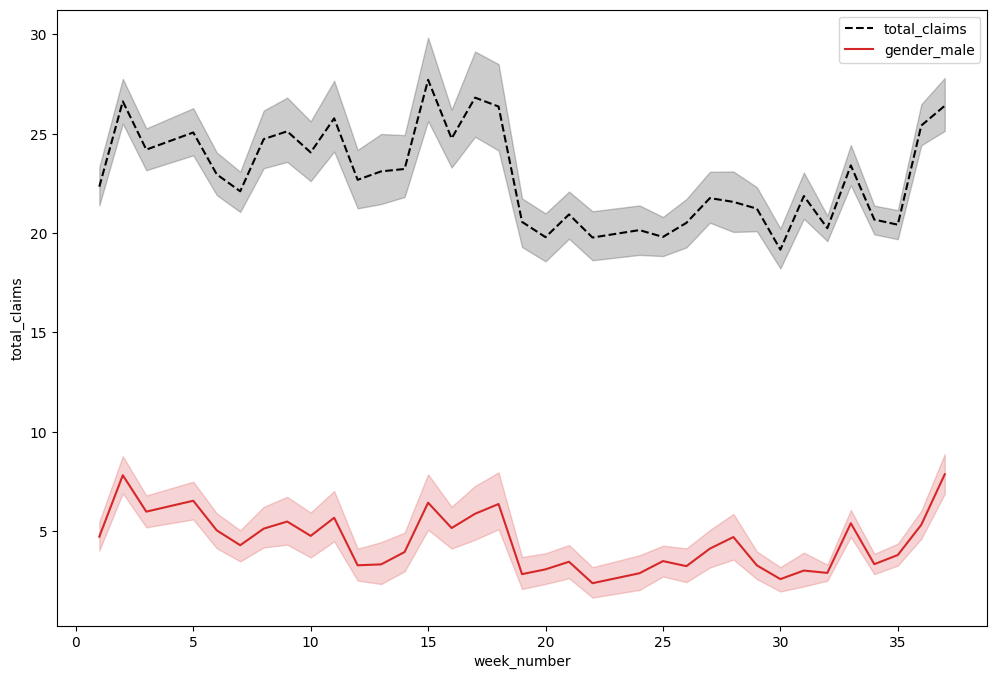

normalized_races (0.5803921568627451, 0.403921568627451, 0.7411764705882353)


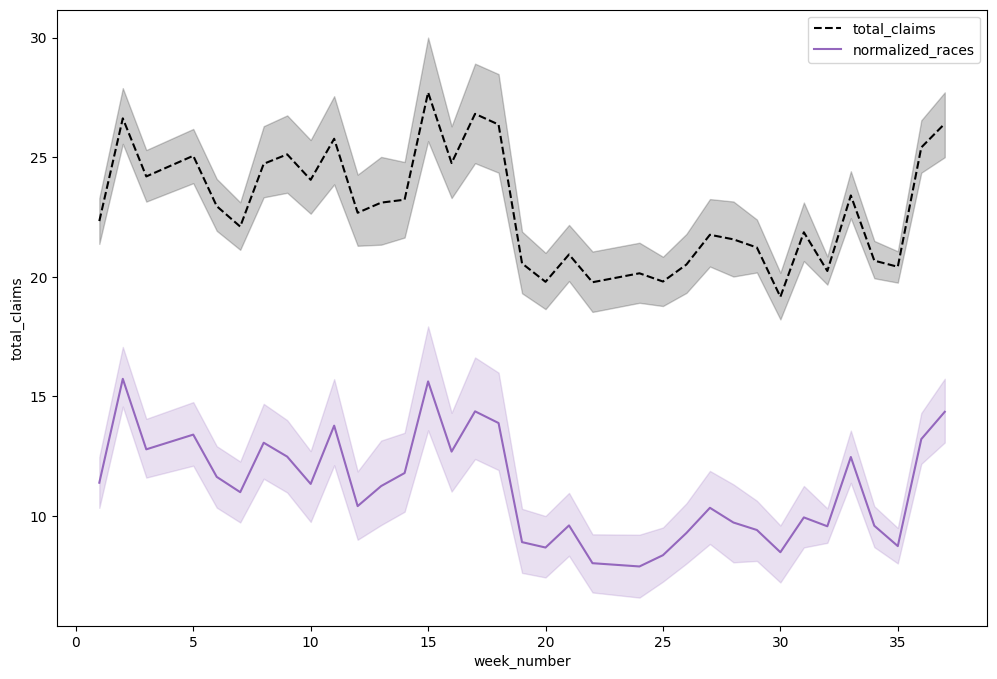

normalized_education (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)


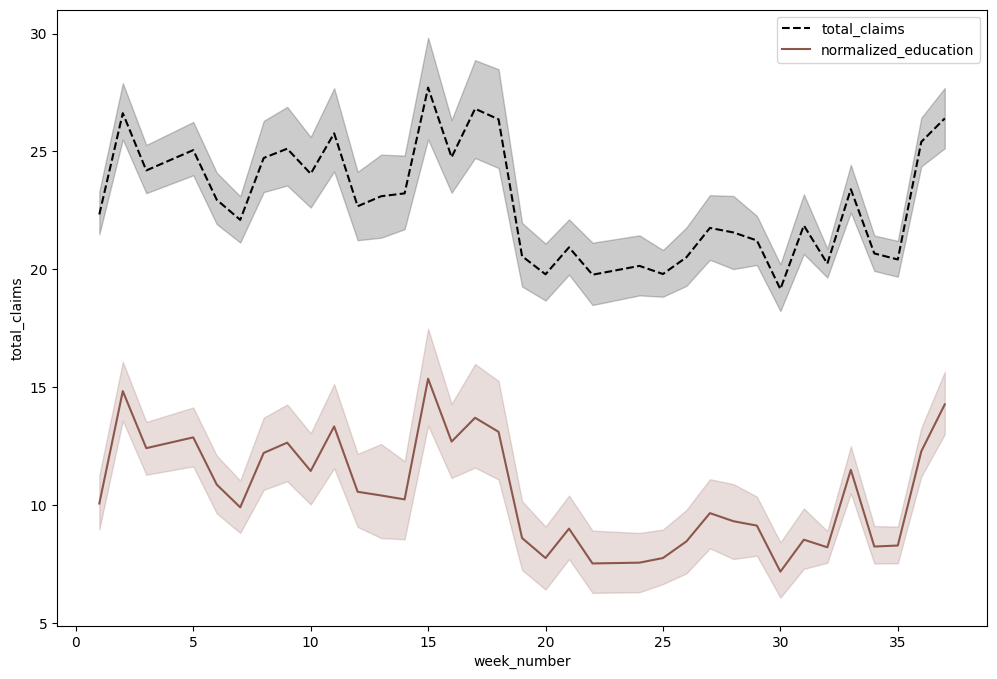

normalized_gender (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)


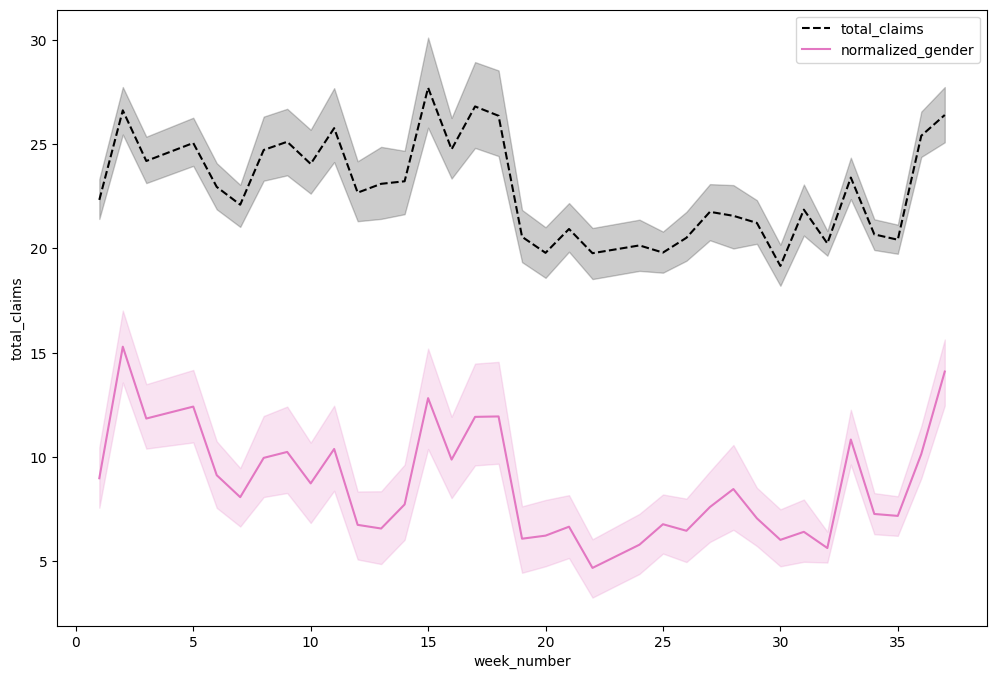

sum (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)


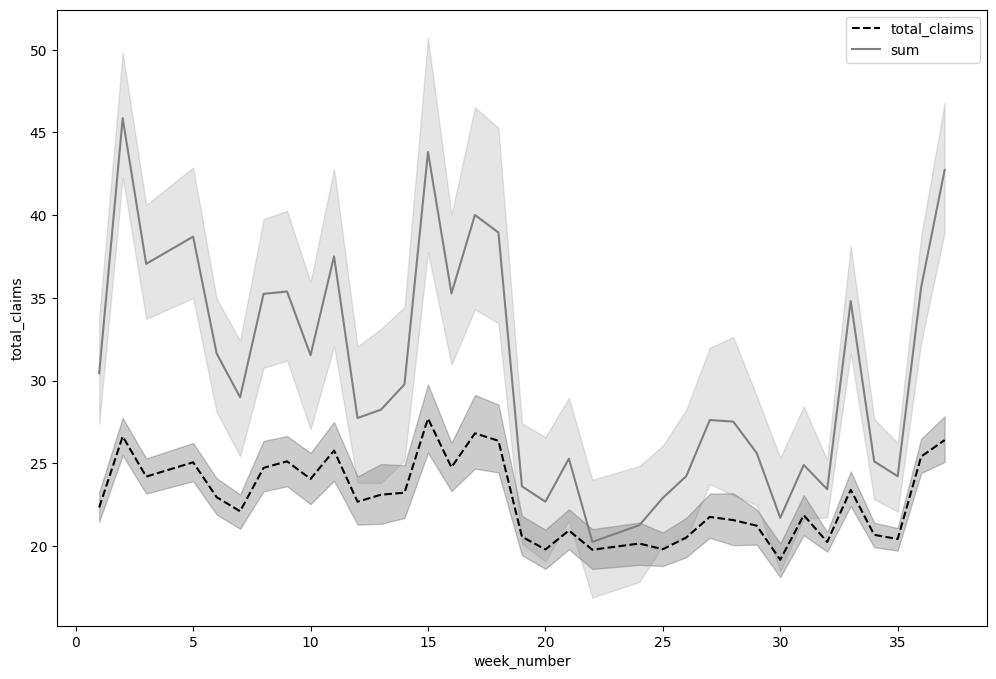

opt_var (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)


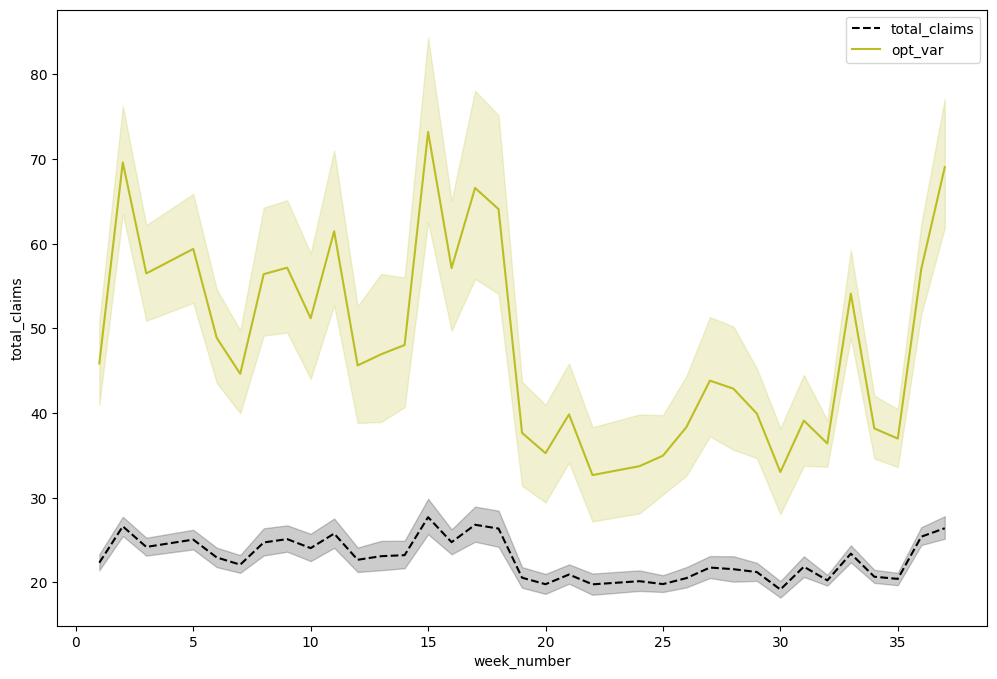

opt_var2 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)


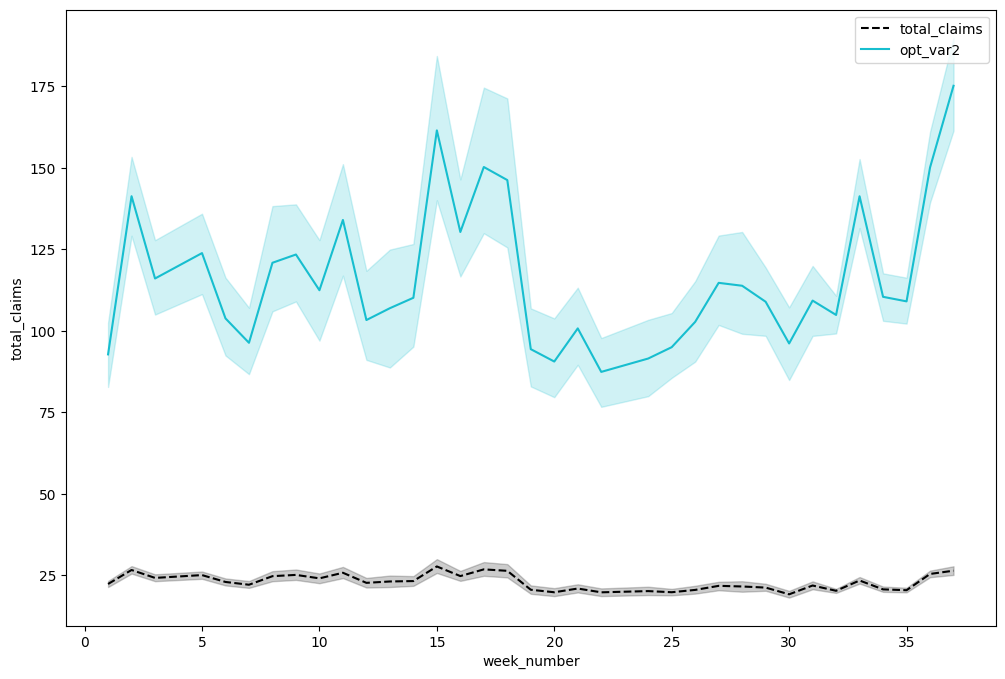

error (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


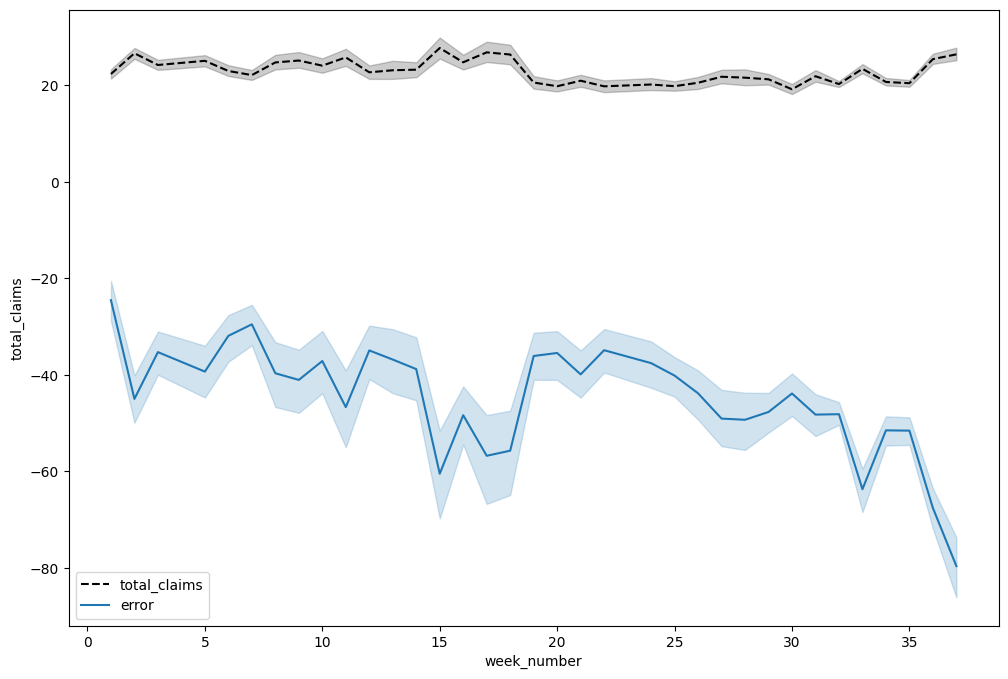

In [30]:
import itertools
colors = itertools.cycle(sns.color_palette("tab10"))
for feature in features:
    fig, ax = plt.subplots(figsize=(12,8)) 
    c = next(colors)
    print(feature, c)
    #sns.scatterplot(x= feature, y = "week_number", data =df3)
    sns.lineplot(y= "total_claims", x = "week_number", data =df3, color = "black", label = "total_claims", linestyle= "--")
    sns.lineplot(y= feature, x = "week_number", data =df3, color = c, label = feature)
    plt.show()

In [31]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as rg
sc = StandardScaler()

In [32]:
def final_pred(t):
    Y = np.array(t["total_claims"])
    X = np.array(t[[k for k in features]])
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size =0.01, random_state =5)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    rf = rg(n_estimators=1000, random_state=2)
    rf.fit(X_train, Y_train)
    return rf

In [33]:
temp = df3[[k for k in features]]
temp

,total_claims,edu_hs_grad_equiv,gender_female,gender_male,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,22.0,14.0,0.0,0.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...
16828,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,16.0,10.0,0.0,0.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,23.0,19.0,0.0,0.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [34]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [35]:
query_job3 = bigquery_client.query(query)
test_df = query_job3.to_dataframe()
#test_df["time"] = pd.datetime(2022-09-24, format = %Y%m%d)
test_df["day"] = 6
test_df["month"]=11

In [36]:
test_df.drop_duplicates()

,uu_id,week_number,day,month
0,5bf51fc2e162d6faf9e3cf79e4198378,44,6,11
1,420b44cc7e3f55d738df565421e59941,44,6,11
2,e39c66ecceec76ee8f9f811fa4a2d246,44,6,11
3,a90462cd11ae4e43144239bf7c4828a4,44,6,11
4,8b20a6749088c7ff1237983076ebfeaa,44,6,11
...,...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,6,11
521,1deebda501712e7595b531b8337bc31a,44,6,11
522,5a9758f65f001b6432ff31ff64a459d7,44,6,11
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,6,11


In [37]:
"""extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())
extra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]
extra"""

'extras = set(test_df.uu_id.unique())-set(submission_prediction_output.uu_id.unique())\nextra = [df.loc[df.uu_id==k]["uu_id_enc"].values[0] for k in extras]\nextra'

In [38]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id").drop(["uu_id"], axis=1).drop_duplicates()
feature_test_pred = test_df.copy()
test_df

,week_number,day,month,uu_id_enc
0,44,6,11,198.0
10,44,6,11,126.0
18,44,6,11,476.0
32,44,6,11,353.0
58,44,6,11,288.0
...,...,...,...,...
16684,44,6,11,144.0
16722,44,6,11,52.0
16757,44,6,11,192.0
16781,44,6,11,486.0


In [39]:
"""test_df1=test_df.copy()
for col in ['total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white', 'average_wage']:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in extra:
        #test_df.loc[test_df.uu_id_enc==k,col] =0
        temp=df[df.uu_id_enc == k]
        temp["average_wage"]=-9999
        temp =temp.replace("",0)
        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])
        #print(k, temp)
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        idk = float(val.predict(np.array(feature_test_pred))[0])
        print(idk)
        test_df.loc[test_df.uu_id_enc==k,col].value  = idk
test_df"""

'test_df1=test_df.copy()\nfor col in [\'total_claims\', \'edu_8th_or_less\', \'edu_grades_9_11\',\n       \'edu_hs_grad_equiv\', \'edu_post_hs\', \'edu_unknown\',\n       \'top_category_employer1\', \'top_category_employer2\',\n       \'top_category_employer3\', \'gender_female\', \'gender_male\', \'gender_na\',\n       \'race_amerindian\', \'race_asian\', \'race_black\', \'race_noanswer\',\n       \'race_hawaiiannative\', \'race_other\', \'race_white\', \'average_wage\']:\n    print(col)\n    test_df[col]=0\n    val = ("rf")+"_"+str(col) \n    for k in extra:\n        #test_df.loc[test_df.uu_id_enc==k,col] =0\n        temp=df[df.uu_id_enc == k]\n        temp["average_wage"]=-9999\n        temp =temp.replace("",0)\n        feature_test_pred = np.array(test_df1[test_df1.uu_id_enc==k])\n        #print(k, temp)\n        val = time_pred(temp, col)\n        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))\n        idk = float(val.predict(np.array(featur

In [40]:
df3

,uu_id,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,month,day,uu_id_enc,normalized_races,normalized_education,normalized_gender,sum,opt_var,opt_var2,error
0,f013068de98db1470bd986137a0c6d23,16.0,18003.0,900.0,451,22.0,0.0,0.0,14.0,0.0,...,4.0,16.0,494.0,11.0,14.0,0.0,25.0,44.988963,105.977927,-38.988963
1,f013068de98db1470bd986137a0c6d23,7.0,18003.0,900.0,451,10.0,0.0,0.0,0.0,0.0,...,2.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,9.000000,2.000000
2,f013068de98db1470bd986137a0c6d23,35.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,8.0,27.0,494.0,0.0,0.0,0.0,0.0,1.000000,37.000000,-25.000000
3,f013068de98db1470bd986137a0c6d23,11.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,3.0,12.0,494.0,0.0,0.0,0.0,0.0,1.000000,13.000000,-1.000000
4,f013068de98db1470bd986137a0c6d23,6.0,18003.0,900.0,451,11.0,0.0,0.0,0.0,0.0,...,2.0,5.0,494.0,0.0,0.0,0.0,0.0,1.000000,8.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16828,33f8f477e670b3cac704f4c0faa6e318,10.0,18113.0,971900.0,516,11.0,0.0,0.0,0.0,0.0,...,3.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,12.000000,0.000000
16829,33f8f477e670b3cac704f4c0faa6e318,6.0,18113.0,971900.0,516,10.0,0.0,0.0,0.0,0.0,...,2.0,5.0,100.0,0.0,0.0,0.0,0.0,1.000000,8.000000,3.000000
16830,33f8f477e670b3cac704f4c0faa6e318,31.0,18113.0,971900.0,516,16.0,0.0,0.0,10.0,0.0,...,7.0,30.0,100.0,0.0,10.0,0.0,10.0,25.827732,82.655463,-40.827732
16831,33f8f477e670b3cac704f4c0faa6e318,9.0,18113.0,971900.0,516,23.0,0.0,0.0,19.0,0.0,...,2.0,26.0,100.0,0.0,19.0,0.0,19.0,49.409365,107.818730,-35.409365


In [41]:
from statsmodels.tsa.stattools import adfuller
adfuller(df3["total_claims"])

(-15.17531611425795,
 6.306874201039816e-28,
 25,
 16807,
 {'1%': -3.430739141371555,
  '5%': -2.8617119850098525,
  '10%': -2.566861543233935},
 134499.30246634077)

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

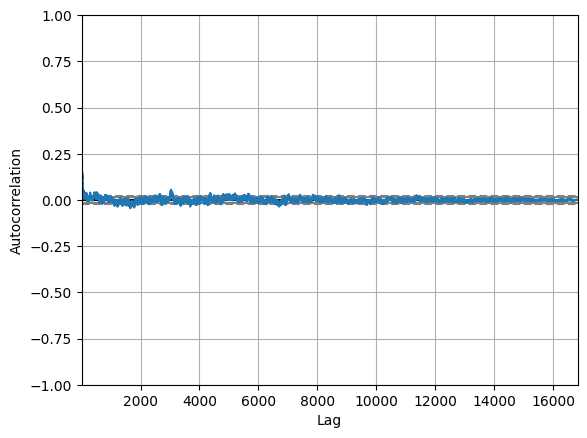

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df3["total_claims"])

In [43]:
df3 =df3.dropna()
for col in features:
    print(col)
    test_df[col]=0
    val = ("rf")+"_"+str(col) 
    for k in df3.uu_id_enc.unique():
        temp=df3[df3.uu_id_enc == k]
        val = time_pred(temp, col)
        #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))
        test_df.loc[test_df.uu_id_enc==k,col] = val.predict(np.array(feature_test_pred))[0]
test_df

total_claims


NameError: name 'time_pred' is not defined

In [44]:
#df3 =df3.dropna()
li=[]
import statsmodels.api as sm
import statistics    
for k in df3.uu_id_enc.unique():
    temp=df3[df3.uu_id_enc == k]
    temp = temp.sort_values("week_number")
    df3_ = pd.concat([temp,test_df])
    df3_=df3_[["week_number","uu_id_enc","total_claims"]].drop_duplicates()
    #df3_["predicted_total_claims"]=0
    mod = sm.tsa.statespace.SARIMAX(np.array(temp["total_claims"]),
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    try: 
        results = mod.fit()
    except IndexError:
        g = df3[df3.uu_id_enc==k]
        val= g[g.week_number==39]['total_claims'].mean()
    pred = results.get_prediction(start=40, end =40, dynamic=False)
    val = (pred.predicted_mean)
    test_df.loc[test_df.uu_id_enc==k,"total_claims"] = val
    li.append(pred.predicted_mean)
    pred_ci = pred.conf_int()
    #print(test_df.loc[test_df.uu_id_enc==k,col],val.predict(np.array(feature_test_pred)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51304D+00    |proj g|=  7.30584D-02

At iterate    5    f=  2.36879D+00    |proj g|=  3.32271D-01

At iterate   10    f=  2.23125D+00    |proj g|=  8.98104D-02

At iterate   15    f=  2.21721D+00    |proj g|=  5.25696D-02

At iterate   20    f=  2.21388D+00    |proj g|=  5.54572D-03

At iterate   25    f=  2.21384D+00    |proj g|=  5.29234D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.30787D+00    |proj g|=  1.33549D-02

At iterate   10    f=  4.28793D+00    |proj g|=  2.41567D-02

At iterate   15    f=  4.25404D+00    |proj g|=  1.10041D-01

At iterate   20    f=  4.18124D+00    |proj g|=  3.51357D-02

At iterate   25    f=  4.15755D+00    |proj g|=  1.31429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   2.262D-05   4.158D+00
  F =   4.1575452566927709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99951D+00    |proj g|=  6.55531D-02

At iterate    5    f=  2.88266D+00    |proj g|=  1.34661D-01

At iterate   10    f=  2.75969D+00    |proj g|=  2.61938D-02

At iterate   15    f=  2.75516D+00    |proj g|=  4.29095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   5.058D-06   2.755D+00
  F =   2.7551425234405604     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  2.73017D+00    |proj g|=  2.09667D-02

At iterate   10    f=  2.69513D+00    |proj g|=  1.66240D-01

At iterate   15    f=  2.68097D+00    |proj g|=  4.24690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     19      1     0     0   1.109D-06   2.681D+00
  F =   2.6809732664732047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01261D+00    |proj g|=  6.64773D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     21      1     0     0   1.841D+15  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19548D+00    |proj g|=  2.88887D-02

At iterate    5    f=  3.18798D+00    |proj g|=  1.33516D-02

At iterate   10    f=  3.17927D+00    |proj g|=  4.65527D-03

At iterate   15    f=  3.17922D+00    |proj g|=  1.96317D-04

       


At iterate   15    f=  2.75653D+00    |proj g|=  2.67999D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   2.680D-06   2.757D+00
  F =   2.7565332919450292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98088D+00    |proj g|=  8.49888D-02

At iterate    5    f=  2.94284D+00    |proj g|=  1.09112D-01

At iterate   10    f=  2.88921D+00    |proj g|=  5.64871D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48428D+00    |proj g|=  1.04692D-01

At iterate    5    f=  3.44432D+00    |proj g|=  2.58522D-02

At iterate   10    f=  3.39994D+00    |proj g|=  1.26853D-01

At iterate   15    f=  3.32217D+00    |proj g|=  5.79645D-02

At iterate   20    f=  3.29514D+00    |proj g|=  8.60600D-03

At iterate   25    f=  3.29505D+00    |proj g|=  1.18221D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     0     0   

  F =   2.5942901909737941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29776D+00    |proj g|=  1.76726D-01

At iterate    5    f=  2.22657D+00    |proj g|=  2.01325D-01

At iterate   10    f=  2.15956D+00    |proj g|=  3.81297D-03

At iterate   15    f=  2.15954D+00    |proj g|=  1.84497D-03

At iterate   20    f=  2.15953D+00    |proj g|=  3.73470D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.41728D+00    |proj g|=  1.15659D-01

At iterate   15    f=  3.39129D+00    |proj g|=  7.45724D-02

At iterate   20    f=  3.36725D+00    |proj g|=  6.68478D-02

At iterate   25    f=  3.36569D+00    |proj g|=  6.32310D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   1.501D-05   3.366D+00
  F =   3.3656934925099700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  2.79915D+00    |proj g|=  9.01520D-02

At iterate   10    f=  2.75466D+00    |proj g|=  7.22235D-02

At iterate   15    f=  2.75427D+00    |proj g|=  3.20157D-03

At iterate   20    f=  2.75417D+00    |proj g|=  1.35116D-02

At iterate   25    f=  2.75416D+00    |proj g|=  2.16913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     35      1     0     0   1.892D-04   2.754D+00
  F =   2.7541616863005745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.59368D+00    |proj g|=  1.98671D-02

At iterate   20    f=  2.59341D+00    |proj g|=  1.50129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     32      1     0     0   1.113D-06   2.593D+00
  F =   2.5934099227177034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16198D+00    |proj g|=  9.92862D-02

At iterate    5    f=  3.13457D+00    |proj g|=  2.93804D-02

At iter


At iterate   20    f=  3.17238D+00    |proj g|=  3.67577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   1.320D-05   3.172D+00
  F =   3.1723847327862513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74138D+00    |proj g|=  1.05070D-01

At iterate    5    f=  2.64484D+00    |proj g|=  2.56389D-01

At iterate   10    f=  2.61516D+00    |proj g|=  1.08053D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.86373D+00    |proj g|=  5.10284D-02

At iterate   15    f=  3.74706D+00    |proj g|=  1.55241D-01

At iterate   20    f=  3.68749D+00    |proj g|=  2.39254D-02

At iterate   25    f=  3.68695D+00    |proj g|=  5.81907D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   5.203D-06   3.687D+00
  F =   3.6869520942362564     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate   15    f=  1.94840D+00    |proj g|=  2.78474D-03

At iterate   20    f=  1.94839D+00    |proj g|=  4.33777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     64      2     0     0   5.341D-05   1.948D+00
  F =   1.9483920423795165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12642D+00    |proj g|=  3.31132D-02

At iterate    5    f=  3.09764D+00    |proj g|=  8.80829D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56521D+00    |proj g|=  2.79226D-01

At iterate   10    f=  1.55181D+00    |proj g|=  5.50535D-02

At iterate   15    f=  1.53975D+00    |proj g|=  8.93721D-02

At iterate   20    f=  1.53472D+00    |proj g|=  3.54795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.223D-06   1.535D+00
  F =   1.5347150909247456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  3.30529D+00    |proj g|=  1.78610D-02

At iterate   10    f=  3.27515D+00    |proj g|=  5.89350D-02

At iterate   15    f=  3.25549D+00    |proj g|=  3.66375D-02

At iterate   20    f=  3.25213D+00    |proj g|=  1.56678D-03

At iterate   25    f=  3.25210D+00    |proj g|=  7.12195D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     31      1     0     0   7.122D-06   3.252D+00
  F =   3.2520981708139631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.76576D+00    |proj g|=  2.21405D-02

At iterate   20    f=  3.76337D+00    |proj g|=  2.82801D-03

At iterate   25    f=  3.76334D+00    |proj g|=  3.22347D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   3.223D-06   3.763D+00
  F =   3.7633389572393763     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22081D+00    |proj g|=  1.42501D-01

At iter


At iterate    5    f=  3.58548D+00    |proj g|=  3.55822D-02

At iterate   10    f=  3.55546D+00    |proj g|=  1.09173D-01

At iterate   15    f=  3.46413D+00    |proj g|=  1.46176D-01

At iterate   20    f=  3.43993D+00    |proj g|=  7.11635D-03

At iterate   25    f=  3.43989D+00    |proj g|=  9.93428D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     42      1     0     0   9.934D-07   3.440D+00
  F =   3.4398892782319539     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35990D-01    |proj g|=  2.76687D-01

At iterate    5    f=  4.56234D-01    |proj g|=  3.15617D-01

At iterate   10    f=  1.85636D-01    |proj g|=  1.48375D+00

At iterate   15    f= -7.58887D-02    |proj g|=  4.42150D+01

At iterate   20    f= -2.58545D-01    |proj g|=  1.14547D+01

At iterate   25    f= -3.12315D-01    |proj g|=  4.87539D+01

At iterate   30    f= -4.84051D-01    |proj g|=  1.50025D+02

At iterate   35    f= -7.01257D-01    |proj g|=  1.30922D+03
  ys=-3.880E-02  -gs= 1.127E-01 BFGS update SKIPPED

At iterate   40    f= -7.75812D-01    |proj g|=  1.02925D+02
  ys=-1.440E-12  -gs= 1.068E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  =

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85254D+00    |proj g|=  1.21236D-01

At iterate    5    f=  2.78718D+00    |proj g|=  6.68174D-02

At iterate   10    f=  2.76055D+00    |proj g|=  9.78025D-02

At iterate   15    f=  2.73193D+00    |proj g|=  1.99047D-03

At iterate   20    f=  2.73183D+00    |proj g|=  5.61739D-03

At iterate   25    f=  2.73181D+00    |proj g|=  5.28702D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3


At iterate   25    f=  3.33674D+00    |proj g|=  8.40273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   2.602D-06   3.337D+00
  F =   3.3367359095431088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83138D+00    |proj g|=  1.32999D-01

At iterate    5    f=  2.78821D+00    |proj g|=  3.21440D-02

At iterate   10    f=  2.77643D+00    |proj g|=  5.71595D-02

At iter


At iterate   10    f=  2.77304D+00    |proj g|=  6.02092D-02

At iterate   15    f=  2.76597D+00    |proj g|=  2.00241D-03

At iterate   20    f=  2.76595D+00    |proj g|=  1.36632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.136D-06   2.766D+00
  F =   2.7659532309003376     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32974D+00    |proj g|=  1.36112D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87682D+00    |proj g|=  1.86285D-01

At iterate    5    f=  2.79079D+00    |proj g|=  4.65121D-02

At iterate   10    f=  2.70853D+00    |proj g|=  3.45773D-02

At iterate   15    f=  2.70495D+00    |proj g|=  9.43208D-03

At iterate   20    f=  2.70478D+00    |proj g|=  1.72629D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.781D-06   2.705D+00
  F =   2.7047821534648366     

CONVERG


At iterate    5    f=  3.11716D+00    |proj g|=  4.94556D-02

At iterate   10    f=  2.99051D+00    |proj g|=  6.11640D-02

At iterate   15    f=  2.98533D+00    |proj g|=  1.03093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   3.011D-05   2.985D+00
  F =   2.9853208596498368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51274D+00    |proj g|=  3.17797D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.36037D+00    |proj g|=  9.23944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   2.203D-05   3.360D+00
  F =   3.3603667437798141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69913D+00    |proj g|=  5.93902D-02

At iterate    5    f=  2.64196D+00    |proj g|=  1.26458D-01

At iterate   10    f=  2.55182D+00    |proj g|=  8.19191D-03

At iter


At iterate   10    f=  3.84433D+00    |proj g|=  1.11786D-01

At iterate   15    f=  3.69825D+00    |proj g|=  1.43661D-02

At iterate   20    f=  3.69772D+00    |proj g|=  2.24999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   2.551D-06   3.698D+00
  F =   3.6977109531670456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75932D+00    |proj g|=  8.30065D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.65340D+00    |proj g|=  6.29900D-03

At iterate   20    f=  3.65333D+00    |proj g|=  3.07771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.594D-06   3.653D+00
  F =   3.6533310651840658     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18866D+00    |proj g|=  1.82914D-01

At iterate    5    f=  3.14814D+00    |proj g|=  1.29956D-01

At iter


At iterate    5    f=  2.89898D+00    |proj g|=  1.07565D-01

At iterate   10    f=  2.84528D+00    |proj g|=  2.07611D-02

At iterate   15    f=  2.84455D+00    |proj g|=  2.82234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     24      1     0     0   7.850D-07   2.845D+00
  F =   2.8445531701083899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.37843D+00    |proj g|=  9.58780D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71222D+00    |proj g|=  6.95437D-02

At iterate    5    f=  2.64999D+00    |proj g|=  9.88866D-02

At iterate   10    f=  2.57977D+00    |proj g|=  3.45400D-02

At iterate   15    f=  2.57659D+00    |proj g|=  3.13251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   3.897D-06   2.577D+00
  F =   2.5765709043881473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  3.12085D+00    |proj g|=  1.15758D-01

At iterate   10    f=  3.03664D+00    |proj g|=  3.81380D-03

At iterate   15    f=  3.03656D+00    |proj g|=  3.18800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.079D-05   3.037D+00
  F =   3.0365572567780550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13042D+00    |proj g|=  8.07076D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.49228D+00    |proj g|=  3.05862D-01

At iterate   10    f=  3.29106D+00    |proj g|=  1.21498D-01

At iterate   15    f=  3.28222D+00    |proj g|=  1.76546D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   3.776D-06   3.282D+00
  F =   3.2822208177725765     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47909D+00    |proj g|=  7.20604D-02

At iter


At iterate   10    f=  3.33349D+00    |proj g|=  2.26037D-01

At iterate   15    f=  3.29891D+00    |proj g|=  8.56643D-02

At iterate   20    f=  3.29811D+00    |proj g|=  4.09094D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   1.952D-05   3.298D+00
  F =   3.2981079339467470     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75169D+00    |proj g|=  2.98850D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.70786D+00    |proj g|=  1.80351D-01

At iterate   15    f=  2.60337D+00    |proj g|=  1.17961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   7.703D-06   2.603D+00
  F =   2.6032717954074229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30986D+00    |proj g|=  1.22352D-01

At iterate    5    f=  2.18831D+00    |proj g|=  8.95416D-02

At iter


At iterate    5    f=  3.13303D+00    |proj g|=  1.14258D-01

At iterate   10    f=  3.03014D+00    |proj g|=  3.28573D-02

At iterate   15    f=  3.02866D+00    |proj g|=  3.25450D-03

At iterate   20    f=  3.02863D+00    |proj g|=  2.66211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     23      1     0     0   2.044D-06   3.029D+00
  F =   3.0286348258748168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.63305D+00    |proj g|=  1.11384D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   3.357D-06   2.633D+00
  F =   2.6330522758566737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.53909D+00    |proj g|=  1.67179D-01

At iterate    5    f=  2.47939D+00    |proj g|=  6.78756D-02

At iterate   10    f=  2.39908D+00    |proj g|=  3.35930D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43368D+00    |proj g|=  9.91287D-02

At iterate    5    f=  1.38592D+00    |proj g|=  3.25080D-02

At iterate   10    f=  1.38442D+00    |proj g|=  4.17520D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.949D-06   1.384D+00
  F =   1.3844155555527133     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.23467D+00    |proj g|=  8.56692D-03

At iterate   30    f=  3.23465D+00    |proj g|=  1.09370D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     44      1     0     0   1.094D-06   3.235D+00
  F =   3.2346525999335203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77938D+00    |proj g|=  1.07426D-01

At iterate    5    f=  2.76980D+00    |proj g|=  3.17767D-02

At iter


At iterate   20    f=  3.68944D+00    |proj g|=  2.09652D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   1.812D-05   3.689D+00
  F =   3.6894397915237338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43351D+00    |proj g|=  1.03550D-01

At iterate    5    f=  3.39678D+00    |proj g|=  7.04976D-02

At iterate   10    f=  3.36737D+00    |proj g|=  7.76745D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.96058D+00    |proj g|=  2.30617D-01

At iterate    5    f=  2.65101D+00    |proj g|=  7.43122D-02

At iterate   10    f=  2.64801D+00    |proj g|=  1.55108D-01

At iterate   15    f=  2.61782D+00    |proj g|=  7.05323D-02

At iterate   20    f=  2.60801D+00    |proj g|=  8.81644D-03

At iterate   25    f=  2.60760D+00    |proj g|=  3.50817D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     39      1     0     0   


At iterate   10    f=  2.74197D+00    |proj g|=  1.15246D-02

At iterate   15    f=  2.74147D+00    |proj g|=  1.59572D-04

At iterate   20    f=  2.74147D+00    |proj g|=  5.01207D-04

At iterate   25    f=  2.74147D+00    |proj g|=  5.08140D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     35      1     0     0   5.081D-06   2.741D+00
  F =   2.7414718721260964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     76      2     0     0   6.047D-02   1.549D+00
  F =   1.5493108951301771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91605D+00    |proj g|=  9.04422D-02

At iterate    5    f=  2.86835D+00    |proj g|=  4.41854D-02

At iterate   10    f=  2.73556D+00    |proj g|=  1.46254D-01

At iterate   15    f=  2.70700D+00    |proj g|=  2.66724D-03

       


At iterate   15    f=  2.45913D+00    |proj g|=  1.54965D-02

At iterate   20    f=  2.45887D+00    |proj g|=  2.25482D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   1.632D-06   2.459D+00
  F =   2.4588724114457876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32973D+00    |proj g|=  4.73321D-02

At iterate    5    f=  2.28283D+00    |proj g|=  6.74619D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50321D+00    |proj g|=  5.49207D-02

At iterate    5    f=  2.43775D+00    |proj g|=  1.68862D-01

At iterate   10    f=  2.39748D+00    |proj g|=  1.63887D-03

At iterate   15    f=  2.39732D+00    |proj g|=  9.36712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   1.027D-05   2.397D+00
  F =   2.3973227340669916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23312D+00    |proj g|=  3.35289D-02

At iterate    5    f=  2.18248D+00    |proj g|=  2.89534D-02

At iterate   10    f=  2.12901D+00    |proj g|=  8.26132D-03

At iterate   15    f=  2.12886D+00    |proj g|=  2.59461D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   5.009D-07   2.129D+00
  F =   2.1288621718755740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate    5    f=  2.24391D+00    |proj g|=  8.39173D-02

At iterate   10    f=  2.13290D+00    |proj g|=  1.05490D-01

At iterate   15    f=  2.11395D+00    |proj g|=  3.84690D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   9.866D-06   2.114D+00
  F =   2.1138918314148323     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23662D+00    |proj g|=  5.54544D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.62793D+00    |proj g|=  3.52513D-02

At iterate   15    f=  2.62247D+00    |proj g|=  2.33595D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   3.825D-07   2.622D+00
  F =   2.6224651116244404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57725D+00    |proj g|=  1.36392D-01

At iterate    5    f=  2.49604D+00    |proj g|=  2.09985D-02

At iter


At iterate   15    f=  3.17060D+00    |proj g|=  8.21590D-03

At iterate   20    f=  3.17059D+00    |proj g|=  1.05026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     32      1     0     0   3.435D-05   3.171D+00
  F =   3.1705853758116533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89839D+00    |proj g|=  3.51528D-02

At iterate    5    f=  1.88867D+00    |proj g|=  2.86073D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.89100D+00    |proj g|=  6.12464D-02

At iterate   15    f=  3.81674D+00    |proj g|=  9.59736D-02

At iterate   20    f=  3.77829D+00    |proj g|=  4.18190D-02

At iterate   25    f=  3.77534D+00    |proj g|=  1.26233D-04

At iterate   30    f=  3.77534D+00    |proj g|=  3.21574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     46      1     0     0   2.050D-05   3.775D+00
  F =   3.7753366194900404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.48504D+00    |proj g|=  5.77934D-02

At iterate    5    f=  2.43714D+00    |proj g|=  7.40031D-02

At iterate   10    f=  2.34289D+00    |proj g|=  2.15408D-02

At iterate   15    f=  2.34243D+00    |proj g|=  1.44531D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.067D-06   2.342D+00
  F =   2.3424279093831228     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50317D+00    |proj g|=  1.39178D-01

At iterate    5    f=  3.46424D+00    |proj g|=  2.82938D-02

At iterate   10    f=  3.44259D+00    |proj g|=  9.13439D-02

At iterate   15    f=  3.30943D+00    |proj g|=  1.65694D-01

At iterate   20    f=  3.27180D+00    |proj g|=  1.25228D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.488D-06   3.272D+00
  F =   3.2716685464247823     

CONVERG

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44635D+00    |proj g|=  2.35123D-01

At iterate    5    f=  3.36623D+00    |proj g|=  7.63682D-02

At iterate   10    f=  3.35442D+00    |proj g|=  2.39361D-02

At iterate   15    f=  3.31859D+00    |proj g|=  1.09612D-01

At iterate   20    f=  3.27025D+00    |proj g|=  3.21011D-02

At iterate   25    f=  3.26974D+00    |proj g|=  1.49068D-03

At iterate   30    f=  3.26973D+00    |proj g|=  4.62852D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.88350D+00    |proj g|=  9.92179D-02

At iterate   15    f=  2.87882D+00    |proj g|=  2.89040D-02

At iterate   20    f=  2.87874D+00    |proj g|=  4.76528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   4.765D-04   2.879D+00
  F =   2.8787396325422012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.81717D+00    |proj g|=  8.50286D-02

At iter


At iterate    5    f=  2.62492D+00    |proj g|=  7.00029D-02

At iterate   10    f=  2.60500D+00    |proj g|=  2.51596D-02

At iterate   15    f=  2.60453D+00    |proj g|=  1.69464D-03

At iterate   20    f=  2.60452D+00    |proj g|=  4.51568D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   1.408D-04   2.605D+00
  F =   2.6045174843051542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  3.56775D+00    |proj g|=  1.28425D-01

At iterate    5    f=  3.51677D+00    |proj g|=  4.21425D-02

At iterate   10    f=  3.40628D+00    |proj g|=  1.09047D-01

At iterate   15    f=  3.34913D+00    |proj g|=  1.41810D-02

At iterate   20    f=  3.34902D+00    |proj g|=  3.76647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     27      1     0     0   8.276D-06   3.349D+00
  F =   3.3490210997203267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


At iterate   10    f=  2.86538D+00    |proj g|=  8.26041D-02

At iterate   15    f=  2.85732D+00    |proj g|=  1.70287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.123D-05   2.857D+00
  F =   2.8573208615256980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12060D+00    |proj g|=  8.26323D-02

At iterate    5    f=  3.09594D+00    |proj g|=  6.93683D-02

At iter


At iterate    5    f=  2.18017D+00    |proj g|=  2.08908D-02

At iterate   10    f=  1.98114D+00    |proj g|=  1.41341D-01

At iterate   15    f=  1.84082D+00    |proj g|=  1.91194D-01

At iterate   20    f=  1.83440D+00    |proj g|=  8.43132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     35      1     0     0   1.776D-06   1.834D+00
  F =   1.8343934254182046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71113D+00    |proj g|=  1.07247D-01

At iterate    5    f=  2.65143D+00    |proj g|=  6.39757D-02

At iterate   10    f=  2.62590D+00    |proj g|=  8.45481D-02

At iterate   15    f=  2.61923D+00    |proj g|=  1.56185D-02

At iterate   20    f=  2.61910D+00    |proj g|=  1.31602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   1.140D-05   2.619D+00
  F =   2.6190981336849188     

CONVERG


At iterate   25    f=  3.81129D+00    |proj g|=  6.64369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   6.884D-06   3.811D+00
  F =   3.8112587175791544     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.50668D+00    |proj g|=  1.62722D-01

At iterate    5    f=  3.41942D+00    |proj g|=  1.40983D-01

At iterate   10    f=  3.27631D+00    |proj g|=  6.02297D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.35026D+00    |proj g|=  2.63735D-02

At iterate   25    f=  2.34952D+00    |proj g|=  2.99743D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     37      1     0     0   6.710D-06   2.350D+00
  F =   2.3495155468749753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.56894D+00    |proj g|=  5.34523D-02

At iterate    5    f=  2.49176D+00    |proj g|=  1.96789D-01

At iter


At iterate   20    f=  2.92390D+00    |proj g|=  1.49929D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   2.903D-05   2.924D+00
  F =   2.9238976371926415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42655D+00    |proj g|=  4.44082D-02

At iterate    5    f=  2.40891D+00    |proj g|=  5.02954D-02

At iterate   10    f=  2.36783D+00    |proj g|=  3.29867D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  2.21405D+00    |proj g|=  1.35646D-01

At iterate    5    f=  2.07152D+00    |proj g|=  2.36645D-01

At iterate   10    f=  1.98603D+00    |proj g|=  7.92651D-03

At iterate   15    f=  1.98570D+00    |proj g|=  2.95066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   2.615D-06   1.986D+00
  F =   1.9857009358335900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82705D+00    |proj g|=  4.81440D-02

At iterate    5    f=  1.81687D+00    |proj g|=  1.34615D-02

At iterate   10    f=  1.80666D+00    |proj g|=  3.39370D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     18      1     0     0   9.393D-06   1.806D+00
  F =   1.8064754853270548     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.74699D+00    |proj g|=  3.23664D-03

At iterate   25    f=  2.74690D+00    |proj g|=  2.87621D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   2.904D-06   2.747D+00
  F =   2.7469030118377202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.98393D+00    |proj g|=  1.19089D-01

At iterate    5    f=  2.92495D+00    |proj g|=  3.22215D-02

At iter


At iterate   10    f=  2.27572D+00    |proj g|=  9.61538D-02

At iterate   15    f=  2.27547D+00    |proj g|=  9.63787D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   5.409D-05   2.275D+00
  F =   2.2754745163239738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60580D+00    |proj g|=  9.64406D-02

At iterate    5    f=  3.56798D+00    |proj g|=  3.15162D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.94081D+00    |proj g|=  4.16570D-02

At iterate   20    f=  1.93943D+00    |proj g|=  2.58270D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   5.480D-06   1.939D+00
  F =   1.9394314418790439     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81419D+00    |proj g|=  1.17624D-01

At iterate    5    f=  2.70842D+00    |proj g|=  9.79113D-02

At iter


At iterate   20    f=  1.11987D+00    |proj g|=  2.49909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   1.191D-06   1.120D+00
  F =   1.1198608392008349     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77612D+00    |proj g|=  8.93789D-02

At iterate    5    f=  2.69690D+00    |proj g|=  1.45998D-01

At iterate   10    f=  2.53189D+00    |proj g|=  2.01140D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69519D+00    |proj g|=  3.67407D-02

At iterate    5    f=  3.68194D+00    |proj g|=  3.21432D-02

At iterate   10    f=  3.63379D+00    |proj g|=  1.40587D-01

At iterate   15    f=  3.60151D+00    |proj g|=  5.24969D-04

At iterate   20    f=  3.59948D+00    |proj g|=  3.00228D-02

At iterate   25    f=  3.59730D+00    |proj g|=  4.64196D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     44      1     0     0   


At iterate   10    f=  3.21742D+00    |proj g|=  4.47460D-02

At iterate   15    f=  3.21570D+00    |proj g|=  3.72169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   5.851D-06   3.216D+00
  F =   3.2156791856970366     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24638D+00    |proj g|=  2.62416D-01

At iterate    5    f=  1.16611D+00    |proj g|=  5.49685D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.27362D+00    |proj g|=  9.75247D-02

At iterate   10    f=  3.16708D+00    |proj g|=  3.44189D-02

At iterate   15    f=  3.16572D+00    |proj g|=  2.58491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   7.479D-06   3.166D+00
  F =   3.1657214468363257     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22173D+00    |proj g|=  6.98690D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90509D+00    |proj g|=  9.26164D-02

At iterate    5    f=  2.86157D+00    |proj g|=  8.09034D-02

At iterate   10    f=  2.78224D+00    |proj g|=  8.56319D-02

At iterate   15    f=  2.76824D+00    |proj g|=  2.31278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   4.484D-05   2.768D+00
  F =   2.7682423828968892     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16695D+00    |proj g|=  1.57448D-01

At iterate    5    f=  2.09088D+00    |proj g|=  6.73062D-02

At iterate   10    f=  2.05732D+00    |proj g|=  1.04541D-02

At iterate   15    f=  2.05725D+00    |proj g|=  6.20643D-04

At iterate   20    f=  2.05725D+00    |proj g|=  1.08166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   1.082D-05   2.057D+00
  F =   2.0572478662826494     

CONVERG


At iterate    5    f=  3.38226D+00    |proj g|=  6.85655D-02

At iterate   10    f=  3.25606D+00    |proj g|=  1.16759D-01

At iterate   15    f=  3.24459D+00    |proj g|=  8.51748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   2.123D-05   3.245D+00
  F =   3.2445859592560033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32182D+00    |proj g|=  8.99820D-02

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.13048D+00    |proj g|=  5.52040D-02

At iterate   15    f=  3.11275D+00    |proj g|=  4.70877D-03

At iterate   20    f=  3.11272D+00    |proj g|=  2.55027D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   2.550D-06   3.113D+00
  F =   3.1127189008846505     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48234D+00    |proj g|=  1.20069D-01

At iter


At iterate    5    f=  3.08629D+00    |proj g|=  8.36771D-02

At iterate   10    f=  2.83367D+00    |proj g|=  7.97300D-02

At iterate   15    f=  2.82148D+00    |proj g|=  4.01349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   1.335D-05   2.821D+00
  F =   2.8214543414365196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15336D+00    |proj g|=  3.36946D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.59304D+00    |proj g|=  7.53560D-03

At iterate   25    f=  2.59278D+00    |proj g|=  3.42906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   8.564D-06   2.593D+00
  F =   2.5927827535550643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16278D+00    |proj g|=  1.08302D-01

At iterate    5    f=  3.10643D+00    |proj g|=  1.77257D-01

At iter


At iterate    5    f=  3.14045D+00    |proj g|=  8.31622D-02

At iterate   10    f=  3.09060D+00    |proj g|=  7.30512D-02

At iterate   15    f=  3.05477D+00    |proj g|=  1.73461D-02

At iterate   20    f=  3.05469D+00    |proj g|=  5.18436D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     31      1     0     0   6.091D-06   3.055D+00
  F =   3.0546878216714877     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.91719D+00    |proj g|=  3.16567D-01

At iterate   10    f=  2.83040D+00    |proj g|=  1.02242D-02

At iterate   15    f=  2.83002D+00    |proj g|=  3.92755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.527D-05   2.830D+00
  F =   2.8300190339524787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.27429D+00    |proj g|=  7.12110D-02

At iter


At iterate   25    f=  2.50295D+00    |proj g|=  1.77896D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     32      1     0     0   1.779D-05   2.503D+00
  F =   2.5029450435551408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.78604D+00    |proj g|=  1.08559D-01

At iterate    5    f=  2.71274D+00    |proj g|=  9.50785D-02

At iterate   10    f=  2.62882D+00    |proj g|=  2.24573D-02

At iter


At iterate   15    f=  1.87298D+00    |proj g|=  2.36803D-02

At iterate   20    f=  1.87200D+00    |proj g|=  6.82521D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   7.035D-06   1.872D+00
  F =   1.8719968607148163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58249D+00    |proj g|=  1.01209D-01

At iterate    5    f=  2.49854D+00    |proj g|=  1.50679D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  3.12862D+00    |proj g|=  1.54584D-02

At iterate   10    f=  3.08469D+00    |proj g|=  1.37971D-02

At iterate   15    f=  3.08419D+00    |proj g|=  1.29132D-02

At iterate   20    f=  3.08356D+00    |proj g|=  5.56134D-02

At iterate   25    f=  3.08052D+00    |proj g|=  5.03531D-03

At iterate   30    f=  3.08012D+00    |proj g|=  8.44193D-03

At iterate   35    f=  3.08008D+00    |proj g|=  6.81633D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   6.816D-06   3.080D+00
  F =   3.0800826273172803     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   


At iterate    5    f=  2.46970D+00    |proj g|=  6.08827D-02

At iterate   10    f=  2.36055D+00    |proj g|=  1.00232D-01

At iterate   15    f=  2.35730D+00    |proj g|=  6.64572D-03

At iterate   20    f=  2.35728D+00    |proj g|=  5.53401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     34      1     0     0   9.534D-05   2.357D+00
  F =   2.3572820521662572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.97537D+00    |proj g|=  1.34322D-01

At iterate   15    f=  2.97415D+00    |proj g|=  1.53479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     26      1     0     0   2.852D-05   2.974D+00
  F =   2.9741522335631640     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33298D+00    |proj g|=  1.00359D-01

At iterate    5    f=  3.28534D+00    |proj g|=  9.42693D-02

At iter


At iterate   10    f=  2.14393D+00    |proj g|=  8.64199D-02

At iterate   15    f=  2.11267D+00    |proj g|=  3.96809D-02

At iterate   20    f=  2.10947D+00    |proj g|=  5.11579D-04

At iterate   25    f=  2.10946D+00    |proj g|=  6.34328D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     34      1     0     0   6.343D-06   2.109D+00
  F =   2.1094611466942115     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.60596D+00    |proj g|=  1.33309D-02

At iterate   15    f=  2.60562D+00    |proj g|=  1.27030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     26      1     0     0   4.187D-06   2.606D+00
  F =   2.6056226268106557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25966D+00    |proj g|=  7.64733D-02

At iterate    5    f=  3.20845D+00    |proj g|=  1.06596D-01

At iter


At iterate   20    f=  3.15657D+00    |proj g|=  1.84333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   2.943D-05   3.157D+00
  F =   3.1565669911694232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03261D+00    |proj g|=  2.54551D-01

At iterate    5    f=  2.70841D+00    |proj g|=  2.57699D-02

At iterate   10    f=  2.63059D+00    |proj g|=  6.17230D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.50605D+00    |proj g|=  7.19227D-02

At iterate   15    f=  3.47605D+00    |proj g|=  2.78692D-02

At iterate   20    f=  3.47295D+00    |proj g|=  8.65343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   3.299D-06   3.473D+00
  F =   3.4729517627699176     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.56075D+00    |proj g|=  2.03194D-01

At iter


At iterate   20    f=  3.19402D+00    |proj g|=  6.31294D-02

At iterate   25    f=  3.19234D+00    |proj g|=  6.08512D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     34      1     0     0   7.499D-06   3.192D+00
  F =   3.1923399425708281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46260D+00    |proj g|=  9.63119D-02

At iterate    5    f=  3.42487D+00    |proj g|=  5.91816D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.97402D+00    |proj g|=  1.00203D-01

At iterate   15    f=  2.96442D+00    |proj g|=  6.69706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   7.514D-07   2.964D+00
  F =   2.9644231232428284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64292D+00    |proj g|=  1.13022D-01

At iterate    5    f=  2.60141D+00    |proj g|=  4.41481D-02

At iter


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   7.190D-06   3.247D+00
  F =   3.2471781719966621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80926D+00    |proj g|=  1.77289D-01

At iterate    5    f=  2.75195D+00    |proj g|=  3.91792D-02

At iterate   10    f=  2.70150D+00    |proj g|=  9.93888D-02

At iterate   15    f=  2.68219D+00    |proj g|=  1.01661D-01

At iter


At iterate    5    f=  3.36132D+00    |proj g|=  3.65052D-02

At iterate   10    f=  3.30463D+00    |proj g|=  1.71809D-01

At iterate   15    f=  3.21996D+00    |proj g|=  4.31217D-02

At iterate   20    f=  3.21824D+00    |proj g|=  1.35238D-03

At iterate   25    f=  3.21824D+00    |proj g|=  8.08482D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   8.085D-06   3.218D+00
  F =   3.2182350125201755     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.79269D+00    |proj g|=  1.18253D-01

At iterate   15    f=  3.68500D+00    |proj g|=  2.20045D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     21      1     0     0   2.057D-05   3.685D+00
  F =   3.6846569831566631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.62714D+00    |proj g|=  1.40655D-01

At iterate    5    f=  3.55451D+00    |proj g|=  3.66318D-02

At iter


At iterate   15    f=  3.37447D+00    |proj g|=  3.48016D-01

At iterate   20    f=  3.37323D+00    |proj g|=  1.12054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     43      1     0     0   4.383D-05   3.373D+00
  F =   3.3732311811996438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.63716D+00    |proj g|=  7.59008D-02

At iterate    5    f=  3.60646D+00    |proj g|=  2.67506D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.32886D+00    |proj g|=  4.96340D-02

At iterate   15    f=  3.30249D+00    |proj g|=  3.62840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   4.266D-06   3.302D+00
  F =   3.3024619537395186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15781D+00    |proj g|=  5.89989D-02

At iterate    5    f=  3.03925D+00    |proj g|=  1.83023D-01

At iter


At iterate    5    f=  3.41709D+00    |proj g|=  1.25334D-01

At iterate   10    f=  3.20893D+00    |proj g|=  4.07438D-02

At iterate   15    f=  3.20723D+00    |proj g|=  1.32675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     23      1     0     0   7.226D-05   3.207D+00
  F =   3.2072327650646422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12603D+00    |proj g|=  8.51949D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.72680D+00    |proj g|=  8.38306D-02

At iterate   15    f=  3.60262D+00    |proj g|=  1.06530D-01

At iterate   20    f=  3.56702D+00    |proj g|=  1.78734D-02

At iterate   25    f=  3.56659D+00    |proj g|=  4.96488D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   1.676D-06   3.567D+00
  F =   3.5665889356598459     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16709D+00    |proj g|=  9.22674D-02

At iterate    5    f=  3.14338D+00    |proj g|=  5.77131D-02

At iterate   10    f=  3.06943D+00    |proj g|=  1.05264D-02

At iterate   15    f=  3.06887D+00    |proj g|=  3.37241D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   3.372D-06   3.069D+00
  F =   3.0688679993727517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.42239D+00    |proj g|=  4.28388D-02

At iterate   15    f=  2.41847D+00    |proj g|=  3.98608D-03

At iterate   20    f=  2.41846D+00    |proj g|=  6.16662D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   6.167D-06   2.418D+00
  F =   2.4184581239513760     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09301D+00    |proj g|=  1.38591D-01

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84383D+00    |proj g|=  1.73862D-01

At iterate    5    f=  3.79572D+00    |proj g|=  1.27180D-02

At iterate   10    f=  3.75617D+00    |proj g|=  5.25401D-02

At iterate   15    f=  3.65486D+00    |proj g|=  1.21798D-01

At iterate   20    f=  3.64302D+00    |proj g|=  1.10184D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   4.361D-06   3.643D+00
  F =   3.6430174855422339     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is u


At iterate   10    f=  3.28020D+00    |proj g|=  1.94465D-02

At iterate   15    f=  3.27840D+00    |proj g|=  8.68860D-03

At iterate   20    f=  3.27834D+00    |proj g|=  6.89226D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   6.892D-06   3.278D+00
  F =   3.2783447838353577     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54122D+00    |proj g|=  5.00077D-02

At iter

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16545D+00    |proj g|=  1.37935D-01

At iterate    5    f=  1.97779D+00    |proj g|=  5.91317D-02

At iterate   10    f=  1.96931D+00    |proj g|=  5.25462D-03

At iterate   15    f=  1.96926D+00    |proj g|=  3.25007D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.250D-07   1.969D+00
  F =   1.9692616134965020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  3.47395D+00    |proj g|=  6.47590D-02

At iterate   25    f=  3.46990D+00    |proj g|=  7.32213D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     45      1     0     0   5.209D-05   3.470D+00
  F =   3.4699016209155480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51236D+00    |proj g|=  1.20196D-01

At iterate    5    f=  3.47892D+00    |proj g|=  3.70701D-02

At iter


At iterate    5    f=  3.25565D+00    |proj g|=  2.54545D-02

At iterate   10    f=  3.16269D+00    |proj g|=  1.08876D-01

At iterate   15    f=  3.10681D+00    |proj g|=  5.65913D-03

At iterate   20    f=  3.10675D+00    |proj g|=  1.03298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.698D-07   3.107D+00
  F =   3.1067471122057189     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.58004D+00    |proj g|=  3.17953D-02

At iterate   15    f=  2.57787D+00    |proj g|=  1.12253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   3.193D-06   2.578D+00
  F =   2.5778700252563240     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91325D+00    |proj g|=  8.21419D-02

At iterate    5    f=  3.88699D+00    |proj g|=  2.59189D-02

At iter


At iterate    5    f=  3.36099D+00    |proj g|=  1.47815D-01

At iterate   10    f=  3.11800D+00    |proj g|=  1.73005D-01

At iterate   15    f=  3.07248D+00    |proj g|=  1.02175D-01

At iterate   20    f=  3.05333D+00    |proj g|=  2.63828D-03

At iterate   25    f=  3.05333D+00    |proj g|=  3.26361D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   3.264D-06   3.053D+00
  F =   3.0533261324707670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85244D+00    |proj g|=  6.61846D-02

At iterate    5    f=  2.82370D+00    |proj g|=  5.38798D-02

At iterate   10    f=  2.73526D+00    |proj g|=  3.32447D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   8.722D-06   2.734D+00
  F =   2.7341923729822670     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.46862D+00    |proj g|=  6.96732D-02

At iterate    5    f=  2.27940D+00    |proj g|=  4.96082D-02

At iterate   10    f=  2.27687D+00    |proj g|=  4.32167D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     23      1     0     0   8.626D-07   2.277D+00
  F =   2.2768677886034818     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.95106D+00    |proj g|=  2.05334D-01

At iterate   10    f=  2.87544D+00    |proj g|=  1.44777D-01

At iterate   15    f=  2.85253D+00    |proj g|=  4.39148D-03

At iterate   20    f=  2.85249D+00    |proj g|=  3.87419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     37      1     0     0   9.298D-05   2.852D+00
  F =   2.8524923570130571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter


At iterate    5    f=  2.69856D+00    |proj g|=  8.24342D-01

At iterate   10    f=  2.66953D+00    |proj g|=  8.96315D-02

At iterate   15    f=  2.65908D+00    |proj g|=  4.29938D-02

At iterate   20    f=  2.65464D+00    |proj g|=  1.39702D+00

At iterate   25    f=  2.64108D+00    |proj g|=  1.27814D-02

At iterate   30    f=  2.64108D+00    |proj g|=  6.63720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     45      1     0     0   2.619D-05   2.641D+00
  F =   2.6410807734538260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.14569D+00    |proj g|=  1.94718D-01

At iterate    5    f=  3.07729D+00    |proj g|=  5.41895D-02

At iterate   10    f=  3.01164D+00    |proj g|=  8.00711D-02

At iterate   15    f=  2.96924D+00    |proj g|=  2.37159D-03

At iterate   20    f=  2.96921D+00    |proj g|=  1.66131D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   1.661D-05   2.969D+00
  F =   2.9692144094281545     

CONVERG


At iterate    5    f=  2.94981D+00    |proj g|=  1.43293D-01

At iterate   10    f=  2.81307D+00    |proj g|=  1.28450D-01

At iterate   15    f=  2.77618D+00    |proj g|=  5.10206D-02

At iterate   20    f=  2.77605D+00    |proj g|=  1.75473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     39      1     0     0   1.437D-03   2.776D+00
  F =   2.7760463482107931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.74998D+00    |proj g|=  3.03100D-02

At iterate   15    f=  3.72304D+00    |proj g|=  2.19265D-02

At iterate   20    f=  3.72237D+00    |proj g|=  4.09495D-03
  ys=-5.024E-04  -gs= 8.936E-04 BFGS update SKIPPED

At iterate   25    f=  3.71744D+00    |proj g|=  2.54691D-02

At iterate   30    f=  3.71678D+00    |proj g|=  7.03766D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     1     0   2.251D-05   3.717D+00
  F =   3.7167760531019045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio


At iterate    5    f=  3.88233D+00    |proj g|=  2.27441D-02

At iterate   10    f=  3.78424D+00    |proj g|=  1.01161D-01

At iterate   15    f=  3.68476D+00    |proj g|=  6.26727D-03

At iterate   20    f=  3.68472D+00    |proj g|=  7.46301D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   7.463D-06   3.685D+00
  F =   3.6847167717387221     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10663D+00    |proj g|=  1.94091D-01

At iterate    5    f=  3.03056D+00    |proj g|=  5.77111D-02

At iterate   10    f=  2.99529D+00    |proj g|=  1.19471D-01

At iterate   15    f=  2.90415D+00    |proj g|=  1.89588D-01

At iterate   20    f=  2.86371D+00    |proj g|=  2.46597D-02

At iterate   25    f=  2.86294D+00    |proj g|=  8.29732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   


At iterate   10    f=  3.62158D+00    |proj g|=  1.46827D-02

At iterate   15    f=  3.58662D+00    |proj g|=  2.32574D-02

At iterate   20    f=  3.58572D+00    |proj g|=  5.70234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     31      1     0     0   2.438D-05   3.586D+00
  F =   3.5857230623453438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.84674D-01    |proj g|=  1.02397D-01

At iter

 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate comp


At iterate   20    f=  1.89233D-01    |proj g|=  4.48551D+01

At iterate   25    f= -6.84002D-01    |proj g|=  1.24110D+03
  ys=-8.305E-03  -gs= 5.222E-03 BFGS update SKIPPED

At iterate   30    f= -1.26133D+00    |proj g|=  3.76289D+02
  ys=-3.777E-04  -gs= 2.538E-03 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35    183      3     2     0   2.965D+02  -1.263D+00
  F =  -1.2625421617797616     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 va

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.71184D+00    |proj g|=  5.98833D-02

At iterate    5    f=  2.68315D+00    |proj g|=  8.41582D-02

At iterate   10    f=  2.65938D+00    |proj g|=  4.33271D-03

At iterate   15    f=  2.65935D+00    |proj g|=  2.74682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   1.483D-05   2.659D+00
  F =   2.6593526937855620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95957D+00    |proj g|=  4.83871D-02

At iterate    5    f=  2.82201D+00    |proj g|=  1.93984D-01

At iterate   10    f=  2.60094D+00    |proj g|=  9.26572D-02

At iterate   15    f=  2.59475D+00    |proj g|=  1.02329D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   9.549D-06   2.595D+00
  F =   2.5947205212028610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate   25    f=  3.27972D+00    |proj g|=  3.65053D-02

At iterate   30    f=  3.27902D+00    |proj g|=  7.12795D-04

At iterate   35    f=  3.27901D+00    |proj g|=  7.83382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     59      1     0     0   7.834D-05   3.279D+00
  F =   3.2790143771901623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45376D+00    |proj g|=  4.60516D-01

At iter


At iterate    5    f=  2.98053D+00    |proj g|=  2.23763D-02

At iterate   10    f=  2.90163D+00    |proj g|=  1.36655D-01

At iterate   15    f=  2.88187D+00    |proj g|=  1.56013D-01

At iterate   20    f=  2.87853D+00    |proj g|=  1.59490D-03

At iterate   25    f=  2.87852D+00    |proj g|=  1.59726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     44      1     0     0   1.597D-05   2.879D+00
  F =   2.8785234146509899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.07848D+00    |proj g|=  3.55485D-03

At iterate   20    f=  3.07845D+00    |proj g|=  1.62110D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   1.621D-06   3.078D+00
  F =   3.0784480763127613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13814D+00    |proj g|=  1.04997D-01

At iterate    5    f=  3.07819D+00    |proj g|=  5.54091D-02

At iter


At iterate   15    f=  3.28867D+00    |proj g|=  9.48649D-02

At iterate   20    f=  3.28359D+00    |proj g|=  9.92975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   3.790D-06   3.284D+00
  F =   3.2835214391706464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54165D+00    |proj g|=  8.20651D-02

At iterate    5    f=  3.51492D+00    |proj g|=  2.05126D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.70717D+00    |proj g|=  5.91422D-02

At iterate   10    f=  3.49004D+00    |proj g|=  9.99922D-02

At iterate   15    f=  3.48147D+00    |proj g|=  3.59951D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   7.481D-07   3.481D+00
  F =   3.4814525280453870     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42580D+00    |proj g|=  5.70741D-02

At iter


At iterate    5    f=  3.86189D+00    |proj g|=  1.65888D-02

At iterate   10    f=  3.81154D+00    |proj g|=  1.53998D-01

At iterate   15    f=  3.64924D+00    |proj g|=  1.18954D-01

At iterate   20    f=  3.62116D+00    |proj g|=  4.28487D-03

At iterate   25    f=  3.62114D+00    |proj g|=  7.86104D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     34      1     0     0   1.873D-06   3.621D+00
  F =   3.6211449264321578     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06840D+00    |proj g|=  7.13667D-02

At iterate    5    f=  3.01256D+00    |proj g|=  1.06195D-01

At iterate   10    f=  2.88752D+00    |proj g|=  6.17542D-02

At iterate   15    f=  2.88235D+00    |proj g|=  1.90490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   3.258D-06   2.882D+00
  F =   2.8823402497625676     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 


At iterate   15    f=  2.13699D+00    |proj g|=  4.22000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     27      1     0     0   8.705D-06   2.137D+00
  F =   2.1369898312155775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32844D+00    |proj g|=  1.57779D-01

At iterate    5    f=  2.19060D+00    |proj g|=  1.06567D-01

At iterate   10    f=  2.16975D+00    |proj g|=  6.61374D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   30    f= -1.12619D-01    |proj g|=  3.07844D+01

At iterate   35    f= -5.12185D-01    |proj g|=  3.36639D+02
  ys=-7.903E+00  -gs= 4.771E-02 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39    136      2     1     0   3.198D+04  -7.565D-01
  F = -0.75654175880235186     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17393D+00    |proj g|=  1.95405D-01

At iterate    5  


At iterate   10    f=  2.06304D+00    |proj g|=  2.67611D-02

At iterate   15    f=  2.05518D+00    |proj g|=  6.56119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   8.077D-07   2.055D+00
  F =   2.0551449969008382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72096D+00    |proj g|=  1.48460D-01

At iterate    5    f=  1.68337D+00    |proj g|=  1.66279D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be s


At iterate   10    f=  2.05461D+00    |proj g|=  4.87797D-02

At iterate   15    f=  2.03059D+00    |proj g|=  2.32547D-02

At iterate   20    f=  2.02948D+00    |proj g|=  7.11205D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     33      1     0     0   4.908D-06   2.029D+00
  F =   2.0294794112334671     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

       


At iterate   10    f=  3.11226D+00    |proj g|=  3.55128D-02

At iterate   15    f=  3.10736D+00    |proj g|=  6.76230D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   4.037D-06   3.107D+00
  F =   3.1073570985033707     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09561D+00    |proj g|=  2.34545D+00

At iterate    5    f=  9.09312D-01    |proj g|=  6.82604D-02

At iter

  ys=-3.829E-12  -gs= 2.690E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47    165      3     1     0   4.935D+00  -5.294D-01
  F = -0.52942649509272788     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.20376D+00    |proj g|=  3.67626D-02

At iterate    5    f=  3.16134D+00    |proj g|=  8.77223D-02

At iterate   10    f=  3.09067D+00    |proj g|=  8.11391D-02

At iterate   15  

 This problem is unconstrained.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.34008D+00    |proj g|=  4.10382D-02

At iterate   10    f=  3.30144D+00    |proj g|=  8.48745D-02

At iterate   15    f=  3.19919D+00    |proj g|=  4.48947D-02

At iterate   20    f=  3.19284D+00    |proj g|=  1.69371D-02

At iterate   25    f=  3.19257D+00    |proj g|=  4.51985D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     43      1     0     0   8.375D-06   3.193D+00
  F =   3.1925684306029889     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


At iterate   15    f=  3.03578D+00    |proj g|=  9.65928D-02

At iterate   20    f=  3.02961D+00    |proj g|=  8.28979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     32      1     0     0   6.041D-05   3.030D+00
  F =   3.0296128436669409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65848D+00    |proj g|=  1.92057D-01

At iterate    5    f=  2.58767D+00    |proj g|=  1.22119D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.11743D-01    |proj g|=  9.06919D-01

At iterate   15    f=  5.69574D-01    |proj g|=  1.91445D-01

At iterate   20    f=  5.54230D-01    |proj g|=  7.01629D-03

At iterate   25    f=  5.54090D-01    |proj g|=  8.03201D-03

At iterate   30    f=  5.30464D-01    |proj g|=  2.65987D-01

At iterate   35    f=  5.21084D-01    |proj g|=  3.41691D-01

At iterate   40    f=  5.17207D-01    |proj g|=  6.30630D-03

At iterate   45    f=  5.16995D-01    |proj g|=  5.43768D-02

At iterate   50    f=  5.16887D-01    |proj g|=  5.47052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     91   

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


In [45]:
test_df

,week_number,day,month,uu_id_enc,total_claims
0,44,6,11,198.0,1.171129e+02
10,44,6,11,126.0,-1.369146e+17
18,44,6,11,476.0,1.351638e+01
32,44,6,11,353.0,-2.228366e+00
58,44,6,11,288.0,1.079835e+01
...,...,...,...,...,...
16684,44,6,11,144.0,4.247554e+01
16722,44,6,11,52.0,3.280737e+01
16757,44,6,11,192.0,1.223219e+01
16781,44,6,11,486.0,1.566907e+00


In [46]:
test_df = pd.merge(test_df, df3[["uu_id","uu_id_enc"]], on="uu_id_enc")
submission_prediction_output= test_df[["uu_id","week_number","total_claims"]].drop_duplicates()
submission_prediction_output["total_claims"] = submission_prediction_output["total_claims"].fillna(0)
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"].value=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output.to_csv("submission_prediction_output.csv")
submission_prediction_output

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,1.171129e+02
10,420b44cc7e3f55d738df565421e59941,44,-1.369146e+17
18,e39c66ecceec76ee8f9f811fa4a2d246,44,1.351638e+01
32,a90462cd11ae4e43144239bf7c4828a4,44,-2.228366e+00
58,8b20a6749088c7ff1237983076ebfeaa,44,1.079835e+01
...,...,...,...
16684,46c4f6c75e663b1ca82ea7994e6d83d3,44,4.247554e+01
16722,1deebda501712e7595b531b8337bc31a,44,3.280737e+01
16757,5a9758f65f001b6432ff31ff64a459d7,44,1.223219e+01
16781,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,1.566907e+00


In [47]:
for k in submission_prediction_output.loc[submission_prediction_output["total_claims"]<=0]["uu_id"]:
    submission_prediction_output.loc[submission_prediction_output["uu_id"]==k,"total_claims"]=df3[df3.uu_id==k]["total_claims"].mean()
submission_prediction_output[submission_prediction_output.total_claims<=0]
submission_prediction_output.to_csv("submission_prediction_output.csv")